In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
import keras
from keras import models
import sys
import logging
sys.path.insert(0, '../')

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

print(tf.__version__)

1.13.1


In [4]:
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils_keras import KerasModelWrapper

In [5]:
from mnist_corruption import gaussian_blurring, corrupt_data, random_perturbation, random_blackout_whiteout

In [24]:
!python --version

Python 2.7.16


### Import the MNIST dataset/ Preprocess the data

In [9]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [10]:
x_train = x_train/255
x_test = x_test/255

In [11]:
num_classes = 10

In [12]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten

In [14]:
from adv_util import create_fully_connected, create_fully_connected_k_onwards

In [15]:
def flatten_mnist(x):
    n, img_rows, img_cols = x.shape
    D = img_rows * img_cols
    x_flattened = x.reshape(n, D)
    return x_flattened, (D, )

In [16]:
x_train_flat, input_shape = flatten_mnist(x_train)
x_test_flat, _ = flatten_mnist(x_test)

In [18]:
small_model = create_fully_connected(input_shape = input_shape, num_classes = num_classes, num_hidden = 4, reg = 0)
small_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
small_model.fit(x_train_flat, y_train, epochs = 10)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60000/60000 [==============================] - 4s 71us/step - loss: 1.3363 - acc: 0.5475: 0s - loss: 1.4683 
Epoch 2/10
60000/60000 [==============================] - 4s 64us/step - loss: 0.5085 - acc: 0.8811
Epoch 3/10
28672/60000 [=============>................] - ETA: 1s - loss: 0.3593 - acc: 0.9124

KeyboardInterrupt: 

# Experiment A

## Helper functions

In [21]:
def dist_calculator(reg_image, adv_image, activation_model):
    reg_image = reg_image.reshape(1, 784)
    adv_image = adv_image.reshape(1, 784)
    activation_reg = np.array(activation_model.predict(reg_image)).squeeze()
    activation_adv = np.array(activation_model.predict(adv_image)).squeeze()
    difference = activation_reg - activation_adv
    L = len(difference)
    if L == 1:
        return np.linalg.norm(activation_reg - activation_adv)
    else:
        distances = []
        for i in range(L):
            distances.append(np.linalg.norm(difference[i]))
        return distances

def dist_average(reg_set, adv_set, activation_model):
    set_card = len(reg_set)
    distances = []
    for i in range(set_card):
        dist = dist_calculator(reg_set[i], adv_set[i], activation_model)
        distances.append(dist)
    #print(np.array(distances).shape)
    return np.average(distances, axis = 0)

def dist_split(x_test_flat, x_test_adv_flat, model, activation_model):
    pred = model.predict(x_test_adv_flat)
    incorrect_indices = [i for i,v in enumerate(pred) if np.argmax(pred[i]) != np.argmax(y_test[i])]
    correct_indices = [i for i,v in enumerate(pred) if np.argmax(pred[i]) == np.argmax(y_test[i])]
    
    overall = dist_average(x_test_flat, x_test_adv_flat, activation_model)
    correct_dist = dist_average(x_test_flat[correct_indices], x_test_adv_flat[correct_indices], activation_model)
    incorrect_dist = dist_average(x_test_flat[incorrect_indices], x_test_adv_flat[incorrect_indices], activation_model)
    
    return overall, correct_dist, incorrect_dist

def adv_generate(session, model_input, epsilon_input, image_set):
    fgsm = FastGradientMethod(model_input, sess=session)
    adv_x = fgsm.generate_np(image_set, eps = epsilon_input, clip_min = -2, clip_max = 2)
    return adv_x

In [22]:
def sum_entries_norm(X):
    return sum(sum(abs(X)))
    
def check_L1(sess):
    small_model = create_fully_connected(input_shape = input_shape, num_classes = num_classes, num_hidden = 2, reg = 0)
    big_model = create_fully_connected(input_shape = input_shape, num_classes = num_classes, num_hidden = 5, reg = 0)
    
    sess.run(tf.global_variables_initializer()) 

    small_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    small_model.fit(x_train_flat, y_train, epochs = 15)
    
    x_test_adv_flat = adv_generate(sess, KerasModelWrapper(small_model), 0.1, x_test_flat)
    print(small_model.evaluate(x_test_adv_flat, y_test))
    
    big_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    big_model.fit(x_train_flat, y_train, epochs = 20)
    x_test_adv_flat = adv_generate(sess, KerasModelWrapper(big_model), 0.1, x_test_flat)
    print(big_model.evaluate(x_test_adv_flat, y_test))
    
    small_model_norms = []
    for layer in small_model.layers: 
        weights = layer.get_weights()
        #norm = np.linalg.norm(weights[0], ord = 1)
        norm = sum_entries_norm(weights[0])
        small_model_norms.append(norm)
    
    large_model_norms = []
    for layer in big_model.layers: 
        weights = layer.get_weights()
        #norm = np.linalg.norm(weights[0], ord = 1)
        norm = sum_entries_norm(weights[0])
        large_model_norms.append(norm)
        
    return small_model_norms, large_model_norms
    

In [57]:
num_hidden_list = range(1,8)
epochs_list = [10,10, 15, 15, 20, 20, 20]

def check_L1_many(sess):
    
    norms_list = []
    accuracies = []
    
    for (idx, num_hidden) in enumerate(num_hidden_list):
        model = create_fully_connected(input_shape = input_shape, num_classes = num_classes, num_hidden = num_hidden, reg = 0) 
        model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
        sess.run(tf.global_variables_initializer()) 
        model.fit(x_train_flat, y_train, epochs = epochs_list[idx])
        x_test_adv_flat = adv_generate(sess, KerasModelWrapper(model), 0.05, x_test_flat)
        print(model.evaluate())
        accuracies.append(model.evaluate(x_test_adv_flat, y_test))

        model_norms = []
        for layer in model.layers:
            weights = layer.get_weights()
            norm = sum_entries_norm(weights[0])
            model_norms.append(norm)
        
        norms_list.append(model_norms)
    
    return norms_list, accuracies

In [58]:
norms_list = check_L1_many(sess)

Epoch 1/10
60000/60000 [==============================] - 6s 95us/step - loss: 0.7433 - acc: 0.8277
Epoch 2/10
60000/60000 [==============================] - 4s 68us/step - loss: 0.2588 - acc: 0.9280
Epoch 3/10
60000/60000 [==============================] - 4s 69us/step - loss: 0.1939 - acc: 0.9447
Epoch 4/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.1600 - acc: 0.9546
Epoch 5/10
60000/60000 [==============================] - 7s 112us/step - loss: 0.1385 - acc: 0.9608 0s - loss: 0.1384 - acc: 0.960
Epoch 6/10
60000/60000 [==============================] - 4s 63us/step - loss: 0.1235 - acc: 0.9649
Epoch 7/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.1113 - acc: 0.9680: 1s
Epoch 8/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.1019 - acc: 0.9700
Epoch 9/10
60000/60000 [==============================] - 5s 81us/step - loss: 0.0934 - acc: 0.9731
Epoch 10/10
60000/60000 [==============================] - 4s 68

[INFO 2019-07-12 18:23:37,935 cleverhans] Constructing new graph for attack FastGradientMethod


10000/10000 [==============================] - 1s 98us/step
Epoch 1/10
60000/60000 [==============================] - 6s 96us/step - loss: 0.9338 - acc: 0.7661
Epoch 2/10
60000/60000 [==============================] - 4s 68us/step - loss: 0.3088 - acc: 0.9187
Epoch 3/10
60000/60000 [==============================] - 4s 70us/step - loss: 0.2174 - acc: 0.9397
Epoch 4/10
60000/60000 [==============================] - 4s 69us/step - loss: 0.1729 - acc: 0.9520: 0s - loss: 0.1748 - a
Epoch 5/10
60000/60000 [==============================] - 4s 68us/step - loss: 0.1459 - acc: 0.9578
Epoch 6/10
60000/60000 [==============================] - 4s 67us/step - loss: 0.1274 - acc: 0.9634
Epoch 7/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.1136 - acc: 0.9670
Epoch 8/10
60000/60000 [==============================] - 4s 67us/step - loss: 0.1027 - acc: 0.9699
Epoch 9/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.0945 - acc: 0.9726
Epoch 10/10
60000

[INFO 2019-07-12 18:24:24,999 cleverhans] Constructing new graph for attack FastGradientMethod


10000/10000 [==============================] - 1s 106us/step
Epoch 1/15
60000/60000 [==============================] - 6s 104us/step - loss: 1.2058 - acc: 0.6298
Epoch 2/15
60000/60000 [==============================] - 5s 77us/step - loss: 0.3947 - acc: 0.9032
Epoch 3/15
60000/60000 [==============================] - 5s 90us/step - loss: 0.2573 - acc: 0.9320: 1s - loss
Epoch 4/15
60000/60000 [==============================] - 5s 85us/step - loss: 0.2064 - acc: 0.9448
Epoch 5/15
60000/60000 [==============================] - 5s 85us/step - loss: 0.1774 - acc: 0.9517
Epoch 6/15
60000/60000 [==============================] - 5s 83us/step - loss: 0.1582 - acc: 0.9564
Epoch 7/15
60000/60000 [==============================] - 5s 84us/step - loss: 0.1424 - acc: 0.9604
Epoch 8/15
60000/60000 [==============================] - 5s 81us/step - loss: 0.1309 - acc: 0.9631
Epoch 9/15
60000/60000 [==============================] - 5s 85us/step - loss: 0.1209 - acc: 0.9660: 0s - loss: 0.1210 - acc: 0

[INFO 2019-07-12 18:25:46,524 cleverhans] Constructing new graph for attack FastGradientMethod


10000/10000 [==============================] - 1s 98us/step
Epoch 1/15
60000/60000 [==============================] - 7s 119us/step - loss: 1.3237 - acc: 0.5444
Epoch 2/15
60000/60000 [==============================] - 6s 106us/step - loss: 0.5628 - acc: 0.8580
Epoch 3/15
60000/60000 [==============================] - 5s 89us/step - loss: 0.3711 - acc: 0.9047
Epoch 4/15
60000/60000 [==============================] - 5s 79us/step - loss: 0.2943 - acc: 0.9233
Epoch 5/15
60000/60000 [==============================] - 5s 77us/step - loss: 0.2513 - acc: 0.9332
Epoch 6/15
60000/60000 [==============================] - 5s 75us/step - loss: 0.2209 - acc: 0.9411
Epoch 7/15
60000/60000 [==============================] - 5s 77us/step - loss: 0.1978 - acc: 0.9463
Epoch 8/15
60000/60000 [==============================] - 5s 75us/step - loss: 0.1830 - acc: 0.9510
Epoch 9/15
60000/60000 [==============================] - 4s 74us/step - loss: 0.1698 - acc: 0.9544
Epoch 10/15
60000/60000 [=============

[INFO 2019-07-12 18:27:05,381 cleverhans] Constructing new graph for attack FastGradientMethod


10000/10000 [==============================] - 1s 106us/step
Epoch 1/20
60000/60000 [==============================] - 7s 114us/step - loss: 1.6510 - acc: 0.3052
Epoch 2/20
60000/60000 [==============================] - 5s 79us/step - loss: 1.1556 - acc: 0.4845
Epoch 3/20
60000/60000 [==============================] - 5s 80us/step - loss: 0.8609 - acc: 0.6518
Epoch 4/20
60000/60000 [==============================] - 5s 80us/step - loss: 0.4739 - acc: 0.8762
Epoch 5/20
60000/60000 [==============================] - 5s 80us/step - loss: 0.3277 - acc: 0.9149
Epoch 6/20
60000/60000 [==============================] - 5s 80us/step - loss: 0.2835 - acc: 0.9256: 1s -
Epoch 7/20
60000/60000 [==============================] - 5s 79us/step - loss: 0.2577 - acc: 0.9323
Epoch 8/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.2397 - acc: 0.9371: 1s
Epoch 9/20
60000/60000 [==============================] - 5s 79us/step - loss: 0.2252 - acc: 0.9409
Epoch 10/20
60000/60000 [===

[INFO 2019-07-12 18:28:56,291 cleverhans] Constructing new graph for attack FastGradientMethod


10000/10000 [==============================] - 1s 108us/step
Epoch 1/20
60000/60000 [==============================] - 11s 187us/step - loss: 1.8039 - acc: 0.2829
Epoch 2/20
60000/60000 [==============================] - 8s 134us/step - loss: 1.1630 - acc: 0.5564
Epoch 3/20
60000/60000 [==============================] - 5s 88us/step - loss: 0.8586 - acc: 0.7232
Epoch 4/20
60000/60000 [==============================] - 6s 106us/step - loss: 0.6615 - acc: 0.8224
Epoch 5/20
60000/60000 [==============================] - 6s 100us/step - loss: 0.3899 - acc: 0.9036
Epoch 6/20
60000/60000 [==============================] - 6s 94us/step - loss: 0.3134 - acc: 0.9207
Epoch 7/20
60000/60000 [==============================] - 6s 102us/step - loss: 0.2815 - acc: 0.9290
Epoch 8/20
60000/60000 [==============================] - 6s 100us/step - loss: 0.2570 - acc: 0.9345
Epoch 9/20
60000/60000 [==============================] - 5s 89us/step - loss: 0.2394 - acc: 0.9389
Epoch 10/20
60000/60000 [=======

[INFO 2019-07-12 18:31:05,480 cleverhans] Constructing new graph for attack FastGradientMethod


10000/10000 [==============================] - 1s 125us/step
Epoch 1/20
60000/60000 [==============================] - 8s 130us/step - loss: 1.9434 - acc: 0.1853
Epoch 2/20
60000/60000 [==============================] - 5s 91us/step - loss: 1.3729 - acc: 0.4443
Epoch 3/20
60000/60000 [==============================] - 6s 92us/step - loss: 1.0646 - acc: 0.5607
Epoch 4/20
60000/60000 [==============================] - 6s 98us/step - loss: 0.9479 - acc: 0.5963
Epoch 5/20
60000/60000 [==============================] - 6s 94us/step - loss: 0.8721 - acc: 0.6220: 
Epoch 6/20
60000/60000 [==============================] - 6s 95us/step - loss: 0.6994 - acc: 0.7255
Epoch 7/20
60000/60000 [==============================] - 6s 94us/step - loss: 0.4484 - acc: 0.8760
Epoch 8/20
60000/60000 [==============================] - 6s 92us/step - loss: 0.3338 - acc: 0.9139
Epoch 9/20
60000/60000 [==============================] - 6s 95us/step - loss: 0.2928 - acc: 0.9225: 0s - loss: 0.2912 - acc: 0
Epoch 10

[INFO 2019-07-12 18:33:08,655 cleverhans] Constructing new graph for attack FastGradientMethod


10000/10000 [==============================] - 1s 131us/step


In [59]:
norms_list, accuracies = norms_list

In [60]:
accuracies

[[7.198563809204102, 0.0883],
 [8.101508946990966, 0.0623],
 [8.493333728027343, 0.0493],
 [7.192939429473877, 0.0636],
 [5.679024671936035, 0.1424],
 [5.903058686828613, 0.1254],
 [6.16216575088501, 0.0934]]

In [66]:
zero = [sum(item) for item in norms_list[0]]
zero

[5347.586502075195, 642.4137744903564, 289.29059982299805]

In [67]:
one = [sum(item) for item in norms_list[1]]
one

[4976.139518737793, 535.55810546875, 606.1693534851074, 259.58698654174805]

In [84]:
two = [sum(item) for item in norms_list[6]]
two

[5592.266632080078,
 454.44677352905273,
 379.2926845550537,
 324.5647220611572,
 315.55324935913086,
 372.345685005188,
 566.3977670669556,
 814.8068647384644,
 223.32340812683105]

In [42]:
sum_norms_large = [sum(item) for item in norm_large]
sum_norms_large

[6102.694839477539,
 486.737585067749,
 374.1345109939575,
 415.886549949646,
 551.9377899169922,
 712.4697360992432,
 234.26904678344727]

In [66]:
norm_ten = check_L1(sess)

Epoch 1/30
60000/60000 [==============================] - 7s - loss: 2.1305 - acc: 0.1606     
Epoch 2/30
60000/60000 [==============================] - 5s - loss: 1.9647 - acc: 0.1958     
Epoch 3/30
60000/60000 [==============================] - 4s - loss: 1.9352 - acc: 0.1991     
Epoch 4/30
60000/60000 [==============================] - 4s - loss: 1.6949 - acc: 0.2841     
Epoch 5/30
60000/60000 [==============================] - 4s - loss: 1.1445 - acc: 0.5237     
Epoch 6/30
60000/60000 [==============================] - 4s - loss: 0.8661 - acc: 0.6869     
Epoch 7/30
60000/60000 [==============================] - 4s - loss: 0.7151 - acc: 0.7712     
Epoch 8/30
60000/60000 [==============================] - 4s - loss: 0.6051 - acc: 0.8420     
Epoch 9/30
60000/60000 [==============================] - 4s - loss: 0.5312 - acc: 0.8658     
Epoch 10/30
60000/60000 [==============================] - 4s - loss: 0.4910 - acc: 0.8762     
Epoch 11/30
60000/60000 [========================

[INFO 2019-06-19 15:05:28,455 cleverhans] Constructing new graph for attack FastGradientMethod



 9920/10000 [============================>.] - ETA: 0s[4.786222448730468, 0.1667]


In [64]:
sum(norm_ten)

471.636323928833

In [62]:
norm_large

[272.09714,
 35.598724,
 16.690395,
 15.194175,
 15.568832,
 14.96835,
 19.503426,
 26.790894,
 49.987755,
 35.301754]

[INFO 2019-06-19 14:00:21,355 cleverhans] Constructing new graph for attack FastGradientMethod


 8512/10000 [========================>.....] - ETA: 0s[0.7929370674490929, 0.8114]


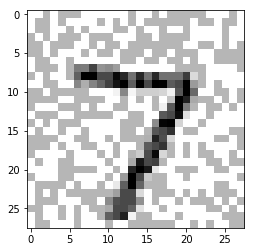

In [47]:
x_test_adv_flat = adv_generate(sess, KerasModelWrapper(big_model), 0.2, x_test_flat)
print(big_model.evaluate(x_test_adv_flat, y_test))
test_image = x_test_adv_flat[0]
two_d = test_image.reshape((28,28))
plt.imshow(two_d, cmap = plt.cm.binary)

In [235]:
x_test_adv_flat = adv_generate(sess, KerasModelWrapper(big_model), 0.1, x_test_flat)
print(big_model.evaluate(x_test_adv_flat, y_test))
L = len(big_model.layers)
layer_output = [big_model.layers[i].output for i in range(L-1)]
activation_model = models.Model(inputs=big_model.input, outputs=layer_output)


[INFO 2019-06-18 14:43:39,597 cleverhans] Constructing new graph for attack FastGradientMethod


 9728/10000 [============================>.] - ETA: 0s[6.337627924346924, 0.1153]


In [236]:
#Train 1 - 10 layers
overall_adv, correct_adv, incorrect_adv = dist_split(x_test_flat, x_test_adv_flat, big_model, activation_model)

In [228]:
# This is the one with 10 hidden layers
incorrect_adv

array([2.4210875, 1.5312514, 1.7560292, 2.130251 , 2.2515316, 2.1644576,
       2.1015663, 2.1409478, 2.3008494, 2.653368 , 2.7827969],
      dtype=float32)

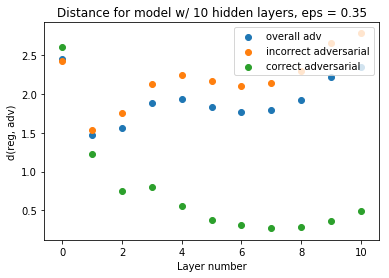

In [234]:
x = range(len(overall_adv))
plt.scatter(x, overall_adv, label = 'overall adv')
plt.scatter(x, incorrect_adv, label = 'incorrect adversarial')
plt.scatter(x, correct_adv, label = 'correct adversarial')

plt.legend(loc='upper right')
plt.xlabel('Layer number')
plt.ylabel('d(reg, adv)')
plt.title('Distance for model w/ 10 hidden layers, eps = 0.35')
plt.show()

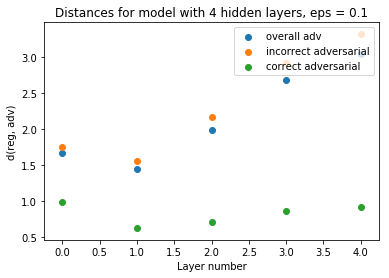

In [237]:
x = range(len(overall_adv))
plt.scatter(x, overall_adv, label = 'overall adv')
plt.scatter(x, incorrect_adv, label = 'incorrect adversarial')
plt.scatter(x, correct_adv, label = 'correct adversarial')

plt.legend(loc='upper right')
plt.xlabel('Layer number')
plt.ylabel('d(reg, adv)')
plt.title('Distances for model with 4 hidden layers, eps = 0.1')
plt.show()

In [238]:
print(correct_adv)
print(incorrect_adv)
print(overall_adv)

[0.9879302  0.6285024  0.7057162  0.8606261  0.92166793]
[1.7530615 1.5531993 2.1585233 2.919911  3.3160417]
[1.6648408 1.4465818 1.9910123 2.6824741 3.0399735]


In [110]:
#Train 10 layers on adversarial examples from 4 layers
#I ran this cell accidentally but it is interesting to see that the distances are less in this case!
#Implying that higher distance definitely has something to do with misclassification.
print(dist_split(x_test_flat, x_test_adv_flat, model, activation_model))

(array([1.8983482e-01, 4.5866568e-02, 1.0599868e-02, 2.4605270e-03,
       5.9164281e-04, 1.3207090e-04, 3.1182546e-05, 6.7690939e-06,
       1.7821782e-06], dtype=float32), array([1.9430134e-01, 4.6853833e-02, 1.0766449e-02, 2.5322465e-03,
       6.1732158e-04, 1.3911516e-04, 3.3157034e-05, 7.2132229e-06,
       1.9057740e-06], dtype=float32), array([1.8930571e-01, 4.5749702e-02, 1.0580133e-02, 2.4520296e-03,
       5.8860087e-04, 1.3123623e-04, 3.0948686e-05, 6.7164951e-06,
       1.7675396e-06], dtype=float32))


In [112]:
#Train 4 layers
print(dist_split(x_test_flat, x_test_adv_flat, model, activation_model))

(array([1.7938548, 1.4845043, 1.9475174, 2.5463245, 2.8488634],
      dtype=float32), array([1.2457126 , 0.7532576 , 0.8118865 , 0.8921975 , 0.97761166],
      dtype=float32), array([1.8587811, 1.5711156, 2.082023 , 2.742242 , 3.0705001],
      dtype=float32))


In [154]:
print(dist_split(x_test_flat, x_test_blur_flat, model, activation_model))

(array([0.55775636, 0.32986605, 0.36812672, 0.4669187 , 0.54217166],
      dtype=float32), array([0.5184117 , 0.28447244, 0.2815359 , 0.31469893, 0.33107078],
      dtype=float32), array([0.761134  , 0.5645054 , 0.81571805, 1.2537409 , 1.6333604 ],
      dtype=float32))


In [155]:
print(dist_split(x_test_flat, x_test_bw_flat, model, activation_model))

(array([1.3607831, 0.9676547, 1.2481122, 1.6766232, 1.9285892],
      dtype=float32), array([0.97070533, 0.58136886, 0.64997876, 0.7937405 , 0.8543499 ],
      dtype=float32), array([1.5935359, 1.1981431, 1.6050072, 2.2034268, 2.5695636],
      dtype=float32))


### Interpretations

- So the reducing from first to second layer seems to consistently hold independent of the number of hidden layers or the random seed used for training.
- The distance from transferred adversarial examples is low - making for an interesting control!
- In the transferrable adversarial example case - The "cascading effect" relationship of increasing distances does not hold!

### Questions

- The decreasing and increasing phenomenon is very interesting from the point of view of better decision boundary versus cascading effect. I'm not sure why it is happening.
- Observe that in the adversarial correct example case, it reduces for multiple layers before it increases. And even at the last layer, it is much less than the first layer.

# Experiment C

In [18]:
sess = tf.keras.backend.get_session()
keras.backend.set_session(sess)

In [20]:
from keras.callbacks import EarlyStopping

#num_hidden_range = range(2, 11, 2)
num_hidden_range = [2,10]
print(num_hidden_range)
regular_metrics = []
#blur_metrics = []
adv_metrics = []
models_saved = []
norms_list = []
early_stop = keras.callbacks.EarlyStopping(monitor='acc', min_delta=0.001, patience=4)


for num_hidden in num_hidden_range:
    print(num_hidden)
    model = create_fully_connected(input_shape = input_shape, num_classes = num_classes, num_hidden = num_hidden, reg = 0)
    print(model.summary())
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])    
    sess.run(tf.global_variables_initializer()) 
    model.fit(x_train_flat, y_train, epochs = 100, callbacks = [early_stop])
    models_saved.append(model)
    regular_metrics.append(model.evaluate(x_test_flat, y_test))
    #blur_metrics.append(model.evaluate(x_test_blur_flat, y_test))
    x_test_adv_flat = adv_generate(sess, KerasModelWrapper(model), 0.05, x_test_flat)
    adv_metrics.append(model.evaluate(x_test_adv_flat, y_test))
    
    model_norms = []
    for layer in model.layers:
        weights = layer.get_weights()
        norm = sum_entries_norm(weights[0])
        model_norms.append(norm)
        
    norms_list.append(model_norms)
        

[2, 10]
2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                25120     
_________________________________________________________________
hidden_0 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                1056      
_________________________________________________________________
last (Dense)                 (None, 10)                330       
Total params: 27,562
Trainable params: 27,562
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
60000/60000 [==============================] - 4s 59us/step - loss: 1.0315 - acc: 0.6898
Epoch 2/100
60000/60000 [==============================] - 3s 57us/step - loss: 0.3421 - acc: 0.9112
Epoch 3/100
60000/60000 [============================

NameError: name 'adv_generate' is not defined

In [186]:
blur_metrics

[[1.5882078989207744, 0.7636],
 [1.5769850840568542, 0.7259],
 [1.2328743010669947, 0.7581],
 [1.2112499143600464, 0.7725],
 [0.730020228600502, 0.8253]]

In [188]:
regular_metrics

[[0.207671465171015, 0.9618],
 [0.23202319830581547, 0.9501],
 [0.22344508992284537, 0.9502],
 [0.22737637112140655, 0.9515],
 [0.3534044238209724, 0.9196]]

In [189]:
adv_metrics

[[8.416653104400634, 0.2148],
 [5.573493826293945, 0.2914],
 [4.364940982437134, 0.2706],
 [4.268519073867798, 0.3421],
 [2.8397580165863037, 0.3978]]

In [187]:
blur_metrics

[[1.5882078989207744, 0.7636],
 [1.5769850840568542, 0.7259],
 [1.2328743010669947, 0.7581],
 [1.2112499143600464, 0.7725],
 [0.730020228600502, 0.8253]]

8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                25120     
_________________________________________________________________
hidden_0 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_4 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_5 (Dense)             (None, 32)                1056      
________

[INFO 2019-06-17 22:50:49,736 cleverhans] Constructing new graph for attack FastGradientMethod


 8544/10000 [========================>.....] - ETA: 0s10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                25120     
_________________________________________________________________
hidden_0 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_4 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_5 (Dense)   

[INFO 2019-06-17 22:50:54,989 cleverhans] Constructing new graph for attack FastGradientMethod


 9248/10000 [==========================>...] - ETA: 0s

## Retrain new model

Hmm... Maybe this is why people have not previously studied the effect of depth on adversarial robustness.. Because the trends are hard to actually establish. 

But the cascading effect certainly seems to hold true. Understanding the cascading versus the decision boundary better would be really interesting

# Experiment B

## Load weights from the previous model 

In [96]:
adv_metrics

[[5.262954145812988, 0.2056],
 [6.705777871704101, 0.163],
 [6.306135898590088, 0.1423],
 [3.6062851570129393, 0.3136],
 [3.116396446990967, 0.3049]]

In [165]:
def adv_generate_intermed_layer_load_weights(session, big_model, k, x_train, y_train):
    print(big_model.summary())
    layer_output = big_model.layers[k-1].output
    activation_model = models.Model(inputs= big_model.input, outputs=layer_output)
    x_train_lifted = activation_model.predict(x_train)
    x_test_lifted = activation_model.predict(x_test_flat)
    print('Found new features')
    
    new_input_shape = (32,)
    model_k = create_fully_connected_k_onwards(input_shape = input_shape, new_input_shape = new_input_shape, k = k, num_classes = num_classes, num_hidden = 4, reg = 0)
    print('Created new model')
    
    print(model_k.summary())
    model_k.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])    
    model_k.load_weights('big_model_weights.h5', by_name=True)
    print(model_k.evaluate(x_test_lifted, y_test))
    
    
    eps_range = np.arange(0.05, 0.35, 0.05)
    accuracies = []
    for eps in eps_range:
        x_test_lifted_adv = adv_generate(session, KerasModelWrapper(model_k), eps, x_test_lifted)
        accuracies.append(model_k.evaluate(x_test_lifted_adv, y_test))
    return model_k, accuracies

In [166]:
model_3_accuracies = adv_generate_intermed_layer_load_weights(sess, big_model, 3, x_train_flat, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                25120     
_________________________________________________________________
hidden_0 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
last (Dense)                 (None, 10)                330       
Total params: 29,674
Trainable params: 29,674
Non-trainable params: 0
_________________________________________________________________
None
F

[INFO 2019-06-17 23:17:26,877 cleverhans] Constructing new graph for attack FastGradientMethod


[0.17925939524397255, 0.9564]
 8992/10000 [=========================>....] - ETA: 0s

[INFO 2019-06-17 23:17:27,941 cleverhans] Constructing new graph for attack FastGradientMethod


 8992/10000 [=========================>....] - ETA: 0s

[INFO 2019-06-17 23:17:28,984 cleverhans] Constructing new graph for attack FastGradientMethod


 9792/10000 [============================>.] - ETA: 0s

[INFO 2019-06-17 23:17:30,112 cleverhans] Constructing new graph for attack FastGradientMethod


 8416/10000 [========================>.....] - ETA: 0s

[INFO 2019-06-17 23:17:31,242 cleverhans] Constructing new graph for attack FastGradientMethod


 8544/10000 [========================>.....] - ETA: 0s

[INFO 2019-06-17 23:17:32,310 cleverhans] Constructing new graph for attack FastGradientMethod


 9824/10000 [============================>.] - ETA: 0s

In [170]:
model_3_accuracies_load = model_3_accuracies
model_2_accuracies_load = adv_generate_intermed_layer_load_weights(sess, big_model, 2, x_train_flat, y_train)
model_1_accuracies_load = adv_generate_intermed_layer_load_weights(sess, big_model, 1, x_train_flat, y_train)
model_4_accuracies_load = adv_generate_intermed_layer_load_weights(sess, big_model, 4, x_train_flat, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                25120     
_________________________________________________________________
hidden_0 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
last (Dense)                 (None, 10)                330       
Total params: 29,674
Trainable params: 29,674
Non-trainable params: 0
_________________________________________________________________
None
F

[INFO 2019-06-17 23:21:31,405 cleverhans] Constructing new graph for attack FastGradientMethod


[0.17925939524397255, 0.9564]
 8288/10000 [=======================>......] - ETA: 0s

[INFO 2019-06-17 23:21:32,609 cleverhans] Constructing new graph for attack FastGradientMethod


 9920/10000 [============================>.] - ETA: 0s

[INFO 2019-06-17 23:21:33,800 cleverhans] Constructing new graph for attack FastGradientMethod


 9568/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-17 23:21:35,117 cleverhans] Constructing new graph for attack FastGradientMethod


 9696/10000 [============================>.] - ETA: 0s

[INFO 2019-06-17 23:21:36,386 cleverhans] Constructing new graph for attack FastGradientMethod


 9184/10000 [==========================>...] - ETA: 0s

[INFO 2019-06-17 23:21:37,857 cleverhans] Constructing new graph for attack FastGradientMethod


 8672/10000 [=========================>....] - ETA: 0s_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                25120     
_________________________________________________________________
hidden_0 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
last (Dense)                 (None, 10)                330       
Total params: 29,674
Trainable params: 29,674
Non-trainable params: 0
__________________

[INFO 2019-06-17 23:21:44,627 cleverhans] Constructing new graph for attack FastGradientMethod


[0.17925939524397255, 0.9564]
 9408/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-17 23:21:46,017 cleverhans] Constructing new graph for attack FastGradientMethod


 8736/10000 [=========================>....] - ETA: 0s

[INFO 2019-06-17 23:21:47,450 cleverhans] Constructing new graph for attack FastGradientMethod


 9856/10000 [============================>.] - ETA: 0s

[INFO 2019-06-17 23:21:48,892 cleverhans] Constructing new graph for attack FastGradientMethod


 9728/10000 [============================>.] - ETA: 0s

[INFO 2019-06-17 23:21:50,472 cleverhans] Constructing new graph for attack FastGradientMethod


 8512/10000 [========================>.....] - ETA: 0s

[INFO 2019-06-17 23:21:51,749 cleverhans] Constructing new graph for attack FastGradientMethod


 9024/10000 [==========================>...] - ETA: 0s_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                25120     
_________________________________________________________________
hidden_0 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
last (Dense)                 (None, 10)                330       
Total params: 29,674
Trainable params: 29,674
Non-trainable params: 0
__________________

[INFO 2019-06-17 23:21:59,324 cleverhans] Constructing new graph for attack FastGradientMethod


[0.17925939524397255, 0.9564]
 9984/10000 [============================>.] - ETA: 0s

[INFO 2019-06-17 23:22:00,736 cleverhans] Constructing new graph for attack FastGradientMethod


 8448/10000 [========================>.....] - ETA: 0s

[INFO 2019-06-17 23:22:02,085 cleverhans] Constructing new graph for attack FastGradientMethod


 9504/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-17 23:22:03,525 cleverhans] Constructing new graph for attack FastGradientMethod


 8384/10000 [========================>.....] - ETA: 0s

[INFO 2019-06-17 23:22:04,867 cleverhans] Constructing new graph for attack FastGradientMethod


 9152/10000 [==========================>...] - ETA: 0s

[INFO 2019-06-17 23:22:06,309 cleverhans] Constructing new graph for attack FastGradientMethod


 8224/10000 [=======================>......] - ETA: 0s

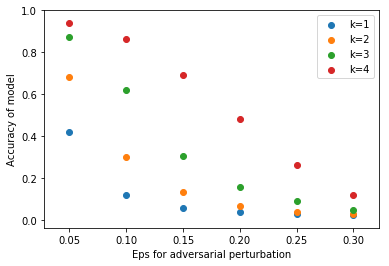

In [172]:
x = np.arange(0.05, 0.35, 0.05)
y_4 = np.array(model_4_accuracies_load[1])[:, 1]
y_3 = np.array(model_3_accuracies_load[1])[:, 1]
y_2 = np.array(model_2_accuracies_load[1])[:, 1]
y_1 = np.array(model_1_accuracies_load[1])[:, 1]
plt.scatter(x, y_1, label = 'k=1')
plt.scatter(x, y_2, label = 'k=2')
plt.scatter(x, y_3, label = 'k=3')
plt.scatter(x, y_4, label = 'k=4')

plt.legend(loc='upper right')
plt.xlabel('Eps for adversarial perturbation')
plt.ylabel('Accuracy of model')
plt.show()

## Retrain the model 

In [164]:
def adv_generate_intermed_layer(session, big_model_input, k, x_train, y_train):
    #Find the new input
    print(model.summary())
    layer_output = model.layers[k-1].output
    activation_model = models.Model(inputs=model.input, outputs=layer_output)
    x_train_lifted = activation_model.predict(x_train)
    x_test_lifted = activation_model.predict(x_test_flat)
    print('Found new features')
    
    #Create the new model
    new_input_shape = (32,)
    model_k = create_fully_connected_k_onwards(input_shape = input_shape, new_input_shape = new_input_shape, k = k, num_classes = num_classes, num_hidden = 4, reg = 0)
    print('Created new model')
    
    #Train on the new input
    print(model_k.summary())
    model_k.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])    
    model_k.fit(x_train_lifted, y_train)
    print('trained new model')
    
    #Create the adversarial examples
    eps_range = np.arange(0.05, 0.35, 0.05)
    accuracies = []
    for eps in eps_range:
        x_test_lifted_adv = adv_generate(session, KerasModelWrapper(model_k), eps, x_test_lifted)
        accuracies.append(model_k.evaluate(x_test_lifted_adv, y_test))
    return accuracies




In [204]:
expt_output = []

In [206]:
model_3_accuracies = adv_generate_intermed_layer(sess, model, 3, x_train_flat, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_158 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_159 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_160 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_161 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_162 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_163 (Dense)            (None, 10)                330       
Total params: 29,674
Trainable params: 29,674
Non-trainable params: 0
_________________________________________________________________
None
F

[INFO 2019-06-12 14:40:10,115 cleverhans] Constructing new graph for attack FastGradientMethod



trained new model
 9312/10000 [==========================>...] - ETA: 0s

[INFO 2019-06-12 14:40:11,577 cleverhans] Constructing new graph for attack FastGradientMethod


 9248/10000 [==========================>...] - ETA: 0s

[INFO 2019-06-12 14:40:12,472 cleverhans] Constructing new graph for attack FastGradientMethod


 9600/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-12 14:40:13,365 cleverhans] Constructing new graph for attack FastGradientMethod


 9440/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-12 14:40:14,255 cleverhans] Constructing new graph for attack FastGradientMethod


 9376/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-12 14:40:15,164 cleverhans] Constructing new graph for attack FastGradientMethod


 9696/10000 [============================>.] - ETA: 0s

In [135]:
model_3_accuracies

(<keras.models.Sequential at 0x1c29c99630>,
 [[3.4218847301483155, 0.0892],
  [3.3436603439331054, 0.0892],
  [3.2765844337463377, 0.0892],
  [3.221594585418701, 0.0892],
  [3.1790746452331544, 0.1428],
  [3.1488127170562743, 0.1756]])

In [140]:
model_4_accuracies = adv_generate_intermed_layer(sess, model, 4, x_train_flat, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                25120     
_________________________________________________________________
hidden_0 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_4 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_5 (Dense)             (None, 32)                1056      
__________

[INFO 2019-06-17 22:58:48,158 cleverhans] Constructing new graph for attack FastGradientMethod



trained new model
 8000/10000 [=======================>......] - ETA: 0s

[INFO 2019-06-17 22:58:49,561 cleverhans] Constructing new graph for attack FastGradientMethod


 8320/10000 [=======================>......] - ETA: 0s

[INFO 2019-06-17 22:58:50,498 cleverhans] Constructing new graph for attack FastGradientMethod


 9696/10000 [============================>.] - ETA: 0s

[INFO 2019-06-17 22:58:51,394 cleverhans] Constructing new graph for attack FastGradientMethod


 9600/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-17 22:58:52,280 cleverhans] Constructing new graph for attack FastGradientMethod


 9504/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-17 22:58:53,219 cleverhans] Constructing new graph for attack FastGradientMethod


 7936/10000 [======================>.......] - ETA: 0s

In [141]:
model_4_accuracies

[[0.1977435935869813, 0.9384],
 [0.39454339797496796, 0.8766],
 [0.9090400233268737, 0.6979],
 [1.875936798286438, 0.3751],
 [3.1674710525512695, 0.1307],
 [4.473508271026612, 0.0572]]

In [210]:
model_1_accuracies = adv_generate_intermed_layer(sess, model, 1, x_train_flat, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_158 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_159 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_160 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_161 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_162 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_163 (Dense)            (None, 10)                330       
Total params: 29,674
Trainable params: 29,674
Non-trainable params: 0
_________________________________________________________________
None
F

[INFO 2019-06-12 14:46:37,467 cleverhans] Constructing new graph for attack FastGradientMethod



trained new model
 9024/10000 [==========================>...] - ETA: 0s

[INFO 2019-06-12 14:46:39,129 cleverhans] Constructing new graph for attack FastGradientMethod


 8928/10000 [=========================>....] - ETA: 0s

[INFO 2019-06-12 14:46:40,137 cleverhans] Constructing new graph for attack FastGradientMethod


 9504/10000 [===========================>..] - ETA: 0s

[INFO 2019-06-12 14:46:42,736 cleverhans] Constructing new graph for attack FastGradientMethod


 9216/10000 [==========================>...] - ETA: 0s

[INFO 2019-06-12 14:46:43,834 cleverhans] Constructing new graph for attack FastGradientMethod


 8192/10000 [=======================>......] - ETA: 0s

[INFO 2019-06-12 14:46:44,927 cleverhans] Constructing new graph for attack FastGradientMethod


 8480/10000 [========================>.....] - ETA: 0s

In [213]:
model_2_accuracies = adv_generate_intermed_layer(sess, model, 2, x_train_flat, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_158 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_159 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_160 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_161 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_162 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_163 (Dense)            (None, 10)                330       
Total params: 29,674
Trainable params: 29,674
Non-trainable params: 0
_________________________________________________________________
None
F

[INFO 2019-06-12 14:50:04,002 cleverhans] Constructing new graph for attack FastGradientMethod



trained new model
 8704/10000 [=========================>....] - ETA: 0s

[INFO 2019-06-12 14:50:05,711 cleverhans] Constructing new graph for attack FastGradientMethod


 9152/10000 [==========================>...] - ETA: 0s

[INFO 2019-06-12 14:50:06,736 cleverhans] Constructing new graph for attack FastGradientMethod


 9888/10000 [============================>.] - ETA: 0s

[INFO 2019-06-12 14:50:07,866 cleverhans] Constructing new graph for attack FastGradientMethod


 8864/10000 [=========================>....] - ETA: 0s

[INFO 2019-06-12 14:50:09,005 cleverhans] Constructing new graph for attack FastGradientMethod


 8800/10000 [=========================>....] - ETA: 0s

[INFO 2019-06-12 14:50:10,052 cleverhans] Constructing new graph for attack FastGradientMethod


 9088/10000 [==========================>...] - ETA: 0s

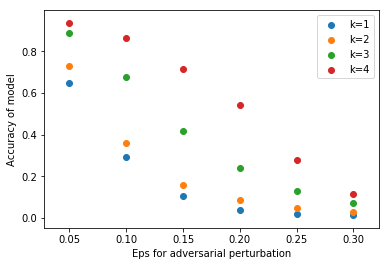

In [217]:
x = np.arange(0.05, 0.35, 0.05)
y_4 = np.array(model_4_accuracies)[:, 1]
y_3 = np.array(model_3_accuracies)[:, 1]
y_2 = np.array(model_2_accuracies)[:, 1]
y_1 = np.array(model_1_accuracies)[:, 1]
plt.scatter(x, y_1, label = 'k=1')
plt.scatter(x, y_2, label = 'k=2')
plt.scatter(x, y_3, label = 'k=3')
plt.scatter(x, y_4, label = 'k=4')

plt.legend(loc='upper right')
plt.xlabel('Eps for adversarial perturbation')
plt.ylabel('Accuracy of model')
plt.show()

### Interpretation

In the above plot, the higher that k is, the shallower the neural net is. As we can see from the plot, the shallower neural nets require higher eps to successfully attack the examples using the FGSM attack. This is in alignment with our hypothesis about the "cascading effect" making it easier to make adversarial examples for deeper networks. 